In [ ]:
# 图谱质量结果表格对比
import json
import pandas as pd
i = 2

def load_kg_quality_row(json_path, method_name):
    """
    从 KG quality eval json 中抽取 relaxed 评估指标
    """
    with open(json_path, "r", encoding="utf-8") as f:
        metrics = json.load(f)

    # metric_name -> value 映射
    metric_dict = {m["metric_name"]: m["value"] for m in metrics}

    row = {
        "Method": method_name,
        "Prec_E": round(metric_dict["relaxed_entity_precision"], 3),
        "Rec_E":  round(metric_dict["relaxed_entity_recall"], 3),
        "F1_E":   round(metric_dict["relaxed_entity_f1"], 3),
        "Prec_R": round(metric_dict["relaxed_relation_precision"], 3),
        "Rec_R":  round(metric_dict["relaxed_relation_recall"], 3),
        "F1_R":   round(metric_dict["relaxed_relation_f1"], 3),
    }
    return row

row_KG1 = load_kg_quality_row(
    r"D:\Desktop\KG_allprocess\Output\Step7_output\test"+str(i)+"_KG_quality.json",
    r"$\mathcal{M}_{K}^{(1)}$"
)

row_KG2 = load_kg_quality_row(
    r"D:\Desktop\KG_allprocess\Output\Step13_output\test"+str(i)+"_KG_quality_updated.json",
    r"$\mathcal{M}_{K}^{(2)}$"
)

print(row_KG1)
print(row_KG2)

df_kg = pd.DataFrame([row_KG1, row_KG2])
df_kg


{'Method': '$\\mathcal{M}_{K}^{(1)}$', 'Prec_E': 0.769, 'Rec_E': 0.732, 'F1_E': 0.75, 'Prec_R': 0.25, 'Rec_R': 0.158, 'F1_R': 0.194}
{'Method': '$\\mathcal{M}_{K}^{(2)}$', 'Prec_E': 0.773, 'Rec_E': 0.829, 'F1_E': 0.8, 'Prec_R': 0.429, 'Rec_R': 0.316, 'F1_R': 0.364}


,Method,Prec_E,Rec_E,F1_E,Prec_R,Rec_R,F1_R
0,$\mathcal{M}_{K}^{(1)}$,0.769,0.732,0.75,0.250,0.158,0.194
1,$\mathcal{M}_{K}^{(2)}$,0.773,0.829,0.80,0.429,0.316,0.364


In [ ]:
# 问题评估结果表格对比
import json
import pandas as pd

def load_eval_row(json_path, method_name):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    row = {
        "Method": method_name,
        "A(q)": round(data["avg_A"], 2),
        "B(q)": round(data["avg_B"], 2),
        "C(q)": round(data["avg_C"], 2),
        "D(q)": round(data["avg_D"], 2),
        "Q(q)": round(data["avg_Q_total"], 2),
        "S(Q^(t))": round(data["suggested_suite_total_with_distribution"], 2)
    }
    return row


row_MQ1 = load_eval_row(
    r"D:\Desktop\KG_allprocess\Output\Step9_output\test"+str(i)+"_MCQ_eval.json",
    r"$\mathcal{M}_{Q}^{(1)}$"
)

row_MQ2 = load_eval_row(
    r"D:\Desktop\KG_allprocess\Output\Step15_output\test"+str(i)+"_MCQ_eval_updated.json",
    r"$\mathcal{M}_{Q}^{(2)}$"
)

print(row_MQ1)
print(row_MQ2)

df = pd.DataFrame([row_MQ1, row_MQ2])
df

{'Method': '$\\mathcal{M}_{Q}^{(1)}$', 'A(q)': 93.33, 'B(q)': 87.5, 'C(q)': 75.0, 'D(q)': 75.0, 'Q(q)': 82.71, 'S(Q^(t))': 85.29}
{'Method': '$\\mathcal{M}_{Q}^{(2)}$', 'A(q)': 87.33, 'B(q)': 84.33, 'C(q)': 80.0, 'D(q)': 80.0, 'Q(q)': 82.92, 'S(Q^(t))': 80.42}


,Method,A(q),B(q),C(q),D(q),Q(q),S(Q^(t))
0,$\mathcal{M}_{Q}^{(1)}$,93.33,87.50,75.0,75.0,82.71,85.29
1,$\mathcal{M}_{Q}^{(2)}$,87.33,84.33,80.0,80.0,82.92,80.42


In [12]:
import pandas as pd
import networkx as nx

def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    # ——节点ID列：如果你 nodes 表不是 id，就改这里，比如 node_id / entity_id
    node_id_col="id",
    # ——边表列：按你文件的真实列名写死
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
    # ——可选：把 confidence 一起读进来
    conf_col="confidence"
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    if node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到 node_id_col='{node_id_col}'，当前列={list(nodes.columns)}")
    for c in [src_col, dst_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")
    if rel_col is not None and rel_col not in edges.columns:
        raise ValueError(f"[edges] 找不到 rel_col='{rel_col}'，当前列={list(edges.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    # 节点
    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        G.add_node(nid, **r.to_dict())

    # 边
    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if rel_col else ""
        attrs = {"relation": rel}

        # 可选保存 confidence
        if conf_col in edges.columns:
            attrs["confidence"] = float(r[conf_col]) if pd.notna(r[conf_col]) else None

        G.add_edge(u, v, **attrs)

    return G


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def edge_keyset(G):
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s

def make_union_graph(*graphs):
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U

def k_hop_nodes_union_graph(G_union, seeds, k=2, max_nodes=80):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited

def draw_graph(ax, G, pos, title):
    ax.set_title(title)
    ax.axis("off")
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=520)
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=12, width=1.4)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=9)

def draw_update_diff(ax, G_base, G_upd, pos, title="Diff (focus): Baseline → Updated"):
    ax.set_title(title)
    ax.axis("off")

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added = upd_edges - base_edges
    removed = base_edges - upd_edges
    kept = base_edges & upd_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    all_nodes = set(G_base.nodes()) | set(G_upd.nodes())
    nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(all_nodes), node_size=520)

    # 不指定颜色：用线型和粗细突出变化
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(kept),    width=1.0, alpha=0.35)
    nx.draw_networkx_edges(G_upd,  pos, ax=ax, edgelist=_to_uv(added),   width=3.2, alpha=0.9)
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(removed), style="dashed", width=2.6, alpha=0.9)

    nx.draw_networkx_labels(G_upd, pos, ax=ax, font_size=9)
    ax.text(0.01, 0.01,
            f"added_edges={len(added)}, removed_edges={len(removed)}, kept_edges={len(kept)}",
            transform=ax.transAxes, fontsize=9, va="bottom")

def plot_focus_subgraph(
    base_nodes, base_edges,
    upd_nodes, upd_edges,
    truth_nodes, truth_edges,
    node_id_col="id",     # 如果 nodes 表不是 id，就改这里
    k=2,
    max_nodes=80,
    out_path="kg_focus_update.png",
    seed=42
):
    # ✅ 按你 edges 表列名读取：src_id/dst_id/relation_type
    G_base  = load_kg_from_tsv(base_nodes,  base_edges,  node_id_col=node_id_col)
    G_upd   = load_kg_from_tsv(upd_nodes,   upd_edges,   node_id_col=node_id_col)
    G_truth = load_kg_from_tsv(truth_nodes, truth_edges, node_id_col=node_id_col)

    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)

    added = upd_e - base_e
    removed = base_e - upd_e

    # 变化中心节点：变化边两端
    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes_union_graph(G_union, changed_nodes, k=k, max_nodes=max_nodes)

    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = nx.spring_layout(union_sub, seed=seed)

    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0]); draw_graph(ax1, base_sub,  pos, f"Baseline (focus, k={k})")
    ax2 = fig.add_subplot(gs[0, 1]); draw_graph(ax2, upd_sub,   pos, f"Updated (focus, k={k})")
    ax3 = fig.add_subplot(gs[1, 0]); draw_graph(ax3, truth_sub, pos, f"Truth (focus, k={k})")
    ax4 = fig.add_subplot(gs[1, 1]); draw_update_diff(ax4, base_sub, upd_sub, pos)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

    print(f"[Saved] {out_path}")
    print(f"[Focus] changed_nodes={len(changed_nodes)}, focus_nodes={len(focus_nodes)} (k={k}, max_nodes={max_nodes})")


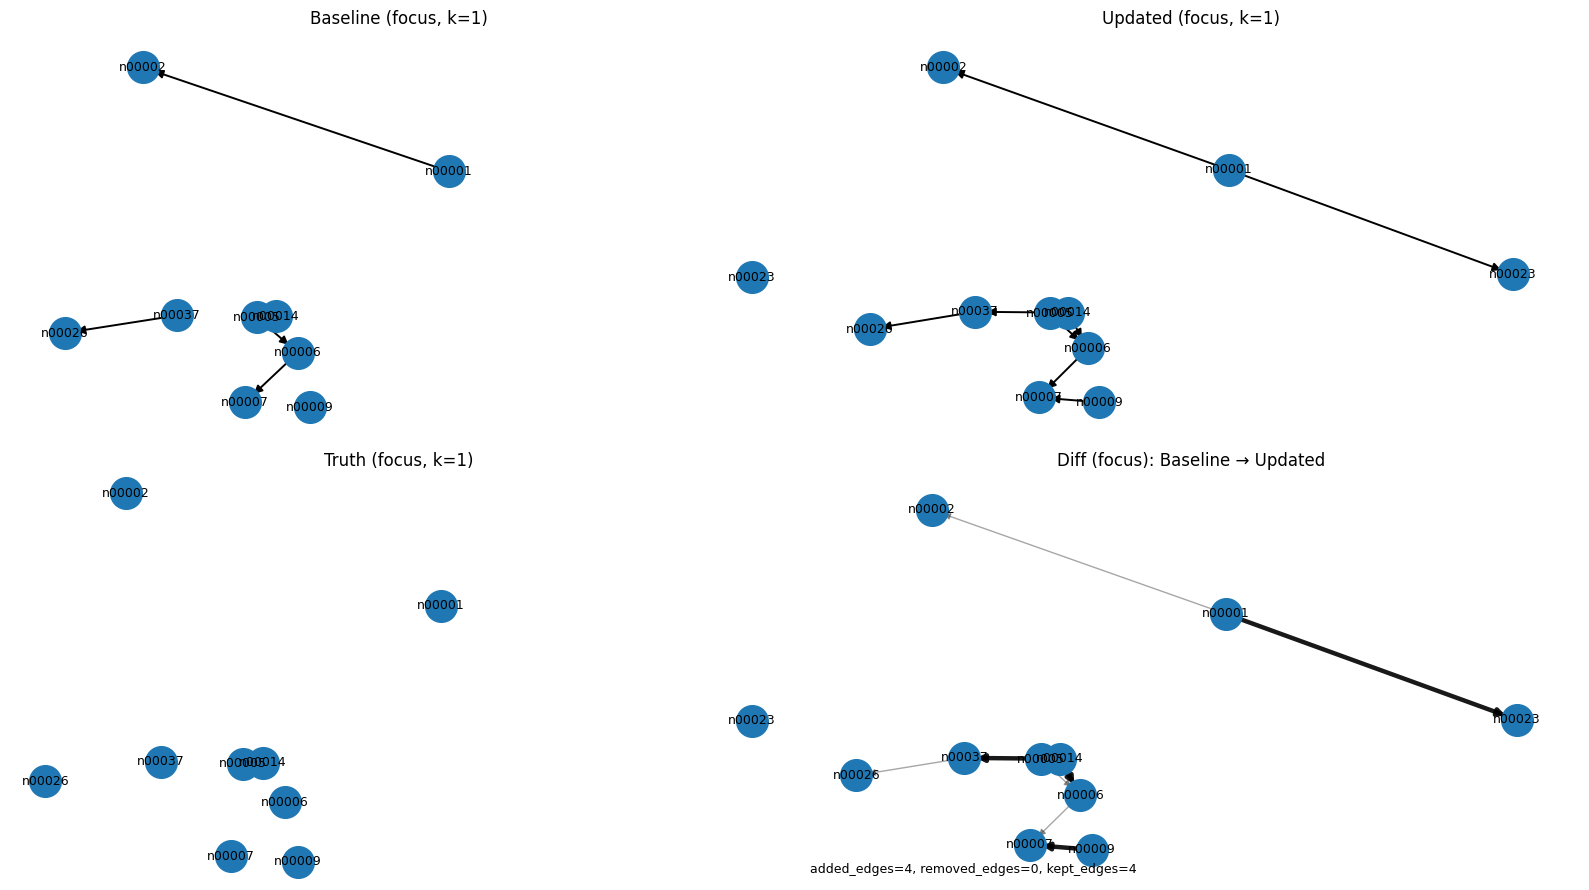

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_update.png
[Focus] changed_nodes=7, focus_nodes=10 (k=1, max_nodes=10)


In [19]:

# ---------------------------
# 4) 你只需要填路径
# ---------------------------
i = 2

plot_focus_subgraph(
    base_nodes=r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv",
    base_edges=r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv",

    upd_nodes=r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv",
    upd_edges=r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv",

    truth_nodes=r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv",
    truth_edges=r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv",
    
    node_id_col="node_id",
    k=1,              # 推荐 1~3；k 越大，范围越广
    max_nodes=10,     # 防止图太大；你可以调小到 30~60 更聚焦
    out_path="D:\\Desktop\\KG_allprocess\\Output\\Step5_output\\Figures\\test"+str(i)+"_kg_focus_update.png",
)


In [21]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# =========================================================
# 0) 你只需要改这里：三套图谱的 nodes/edges 路径
# =========================================================
i = 2

BASE_NODES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv"
BASE_EDGES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv"

UPD_NODES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv"
UPD_EDGES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv"
# 真值图谱路径（按你实际文件改）
TRUTH_NODES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv"
TRUTH_EDGES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv"

# 输出图片保存路径（确保目录存在）
OUT_PATH    = r"D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test"+str(i)+"_kg_focus_update.png"
# 聚焦参数：k 越大范围越广；max_nodes 越小越聚焦
K_HOP       = 1
MAX_NODES   = 10

# 你的列名已知：nodes里实体名列是 name；edges里 src_id/dst_id/relation_type
NODE_NAME_COL = "name"
EDGE_SRC_COL  = "src_id"
EDGE_DST_COL  = "dst_id"
EDGE_REL_COL  = "relation_type"

# nodes 表中“节点ID列”你如果不确定，下面会自动猜；也可以写死比如 "id" / "node_id"
NODE_ID_COL_CANDIDATES = ["id", "node_id", "entity_id", "nid"]


# =========================================================
# 1) 读取图谱：NetworkX (DiGraph)
# =========================================================
def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    node_id_col=None,
    node_name_col="name",
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    # 自动确定 node_id_col
    if node_id_col is None:
        for cand in NODE_ID_COL_CANDIDATES:
            if cand in nodes.columns:
                node_id_col = cand
                break
    if node_id_col is None or node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到节点ID列。当前列={list(nodes.columns)}；请把 node_id_col 写死成其中一列。")

    # 检查必要列
    for c in [src_col, dst_col, rel_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")

    if node_name_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到实体名列 '{node_name_col}'，当前列={list(nodes.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    # 节点：存 display_name，用于绘图
    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        attrs = r.to_dict()
        attrs["display_name"] = str(r[node_name_col]) if pd.notna(r[node_name_col]) else nid
        G.add_node(nid, **attrs)

    # 边：存 relation（来自 relation_type）
    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if pd.notna(r[rel_col]) else ""
        G.add_edge(u, v, relation=rel)

    return G


def edge_keyset(G):
    """把边映射成 (u, relation, v) 的集合，便于做差分/TP FP FN 等"""
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s


def make_union_graph(*graphs):
    """联合图，用于统一布局/做 k-hop 扩展时不漏邻居"""
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U


# =========================================================
# 2) k-hop 聚焦：从变化边端点出发扩展邻域
# =========================================================
def k_hop_nodes(G_union, seeds, k=2, max_nodes=60):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited


# =========================================================
# 3) 绘图：节点显示 name；边显示 relation_type
# =========================================================
def draw_graph(ax, G, pos, title, node_font_size=9, edge_font_size=8):
    ax.set_title(title)
    ax.axis("off")

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=520)
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=12, width=1.4)

    node_labels = {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, ax=ax, labels=node_labels, font_size=node_font_size)

    edge_labels = {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edge_labels, font_size=edge_font_size)


def draw_update_diff(ax, G_base, G_upd, pos, title="Diff (focus): Baseline → Updated"):
    ax.set_title(title)
    ax.axis("off")

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added   = upd_edges - base_edges
    removed = base_edges - upd_edges
    kept    = base_edges & upd_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    all_nodes = set(G_base.nodes()) | set(G_upd.nodes())
    nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(all_nodes), node_size=520)

    # 不指定颜色：用线型+粗细突出变化
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(kept),    width=1.0, alpha=0.25)
    nx.draw_networkx_edges(G_upd,  pos, ax=ax, edgelist=_to_uv(added),   width=3.2, alpha=0.9)
    nx.draw_networkx_edges(G_base, pos, ax=ax, edgelist=_to_uv(removed), style="dashed", width=2.6, alpha=0.9)

    # 节点标签：实体 name
    node_labels = {n: G_upd.nodes[n].get("display_name", str(n)) for n in all_nodes}
    nx.draw_networkx_labels(G_upd, pos, ax=ax, labels=node_labels, font_size=9)

    # 只给变化边打标签（更清晰、更突出更新）
    change_edge_labels = {}
    for (u, rel, v) in added:
        change_edge_labels[(u, v)] = rel
    for (u, rel, v) in removed:
        change_edge_labels[(u, v)] = rel

    nx.draw_networkx_edge_labels(G_upd, pos, ax=ax, edge_labels=change_edge_labels, font_size=8)

    ax.text(
        0.01, 0.01,
        f"added_edges={len(added)}, removed_edges={len(removed)}, kept_edges={len(kept)}",
        transform=ax.transAxes, fontsize=9, va="bottom"
    )


# =========================================================
# 4) 主函数：只画“更新变化附近”的子图
# =========================================================
def plot_focus_update_subgraph(
    base_nodes, base_edges,
    upd_nodes, upd_edges,
    truth_nodes, truth_edges,
    out_path,
    k=2,
    max_nodes=60,
    seed=42
):
    # 读图
    G_base  = load_kg_from_tsv(base_nodes,  base_edges,  node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_upd   = load_kg_from_tsv(upd_nodes,   upd_edges,   node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_truth = load_kg_from_tsv(truth_nodes, truth_edges, node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)

    # 找变化边
    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)
    added = upd_e - base_e
    removed = base_e - upd_e

    # 变化中心节点：变化边端点
    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    if not changed_nodes:
        print("[Warn] 没有检测到新增/删除边（baseline 与 updated 边集合完全相同）。将画全图可能更合适。")

    # 联合图上做 k-hop
    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes(G_union, changed_nodes, k=k, max_nodes=max_nodes) if changed_nodes else set(G_union.nodes())

    # 子图
    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    # 统一布局（在聚焦联合子图上算）
    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = nx.spring_layout(union_sub, seed=seed)

    # 画图：2x2
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0]); draw_graph(ax1, base_sub,  pos, f"Baseline (focus, k={k})")
    ax2 = fig.add_subplot(gs[0, 1]); draw_graph(ax2, upd_sub,   pos, f"Updated (focus, k={k})")
    ax3 = fig.add_subplot(gs[1, 0]); draw_graph(ax3, truth_sub, pos, f"Truth (focus, k={k})")
    ax4 = fig.add_subplot(gs[1, 1]); draw_update_diff(ax4, base_sub, upd_sub, pos)

    plt.tight_layout()

    # 确保目录存在
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=300)
    plt.show()

    print(f"[Saved] {out_path}")
    print(f"[Focus] changed_nodes={len(changed_nodes)}, focus_nodes={len(focus_nodes)} (k={k}, max_nodes={max_nodes})")


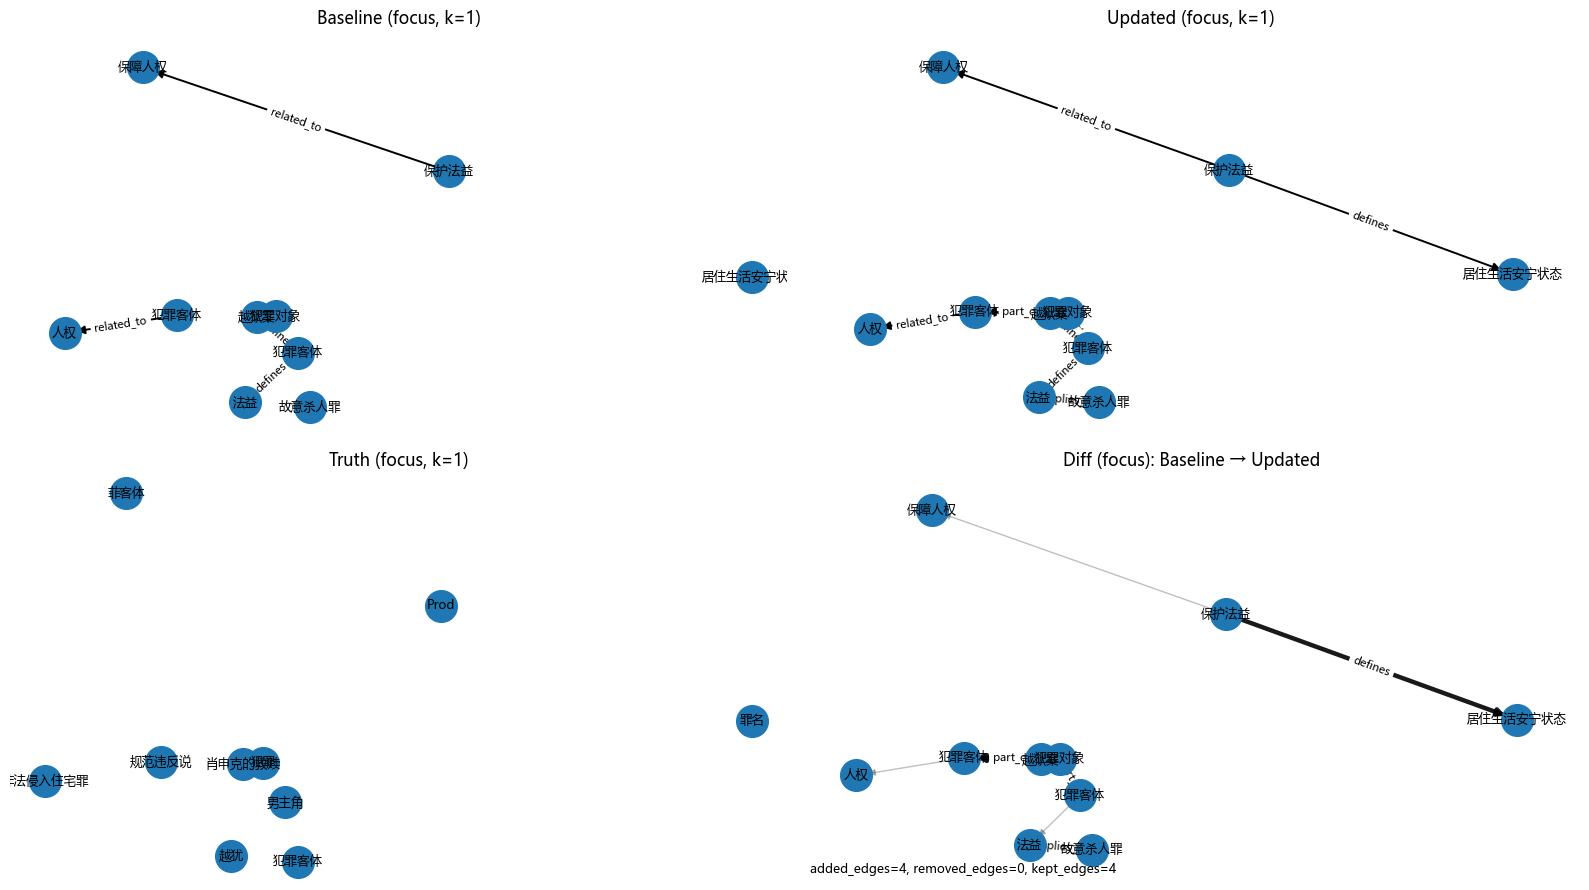

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test2_kg_focus_update.png
[Focus] changed_nodes=7, focus_nodes=10 (k=1, max_nodes=10)


In [22]:
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
# =========================================================
# 5) 运行
# =========================================================
plot_focus_update_subgraph(
    base_nodes=BASE_NODES, base_edges=BASE_EDGES,
    upd_nodes=UPD_NODES,   upd_edges=UPD_EDGES,
    truth_nodes=TRUTH_NODES, truth_edges=TRUTH_EDGES,
    out_path=OUT_PATH,
    k=K_HOP,
    max_nodes=MAX_NODES
)


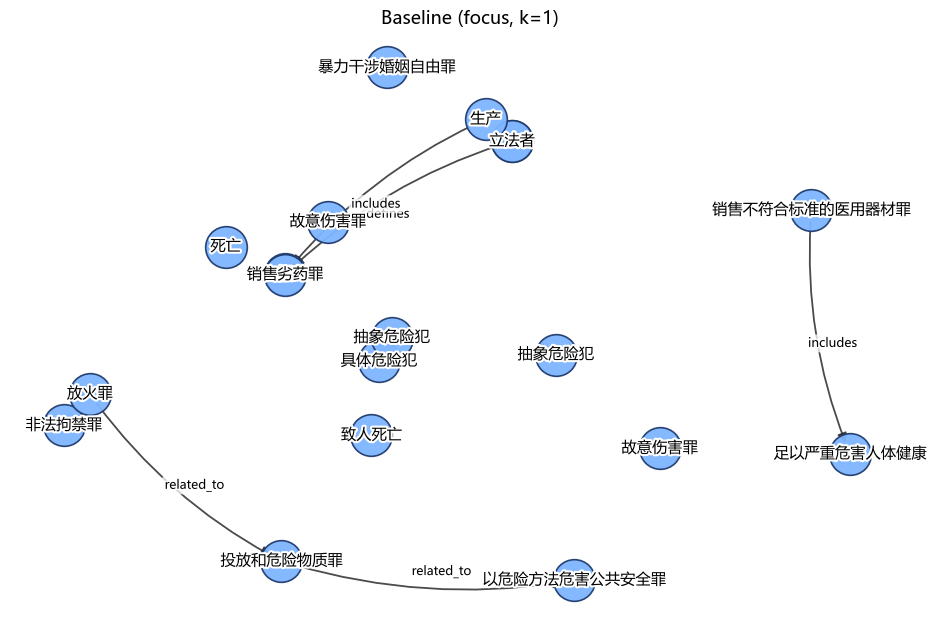

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test5_kg_focus_baseline.png


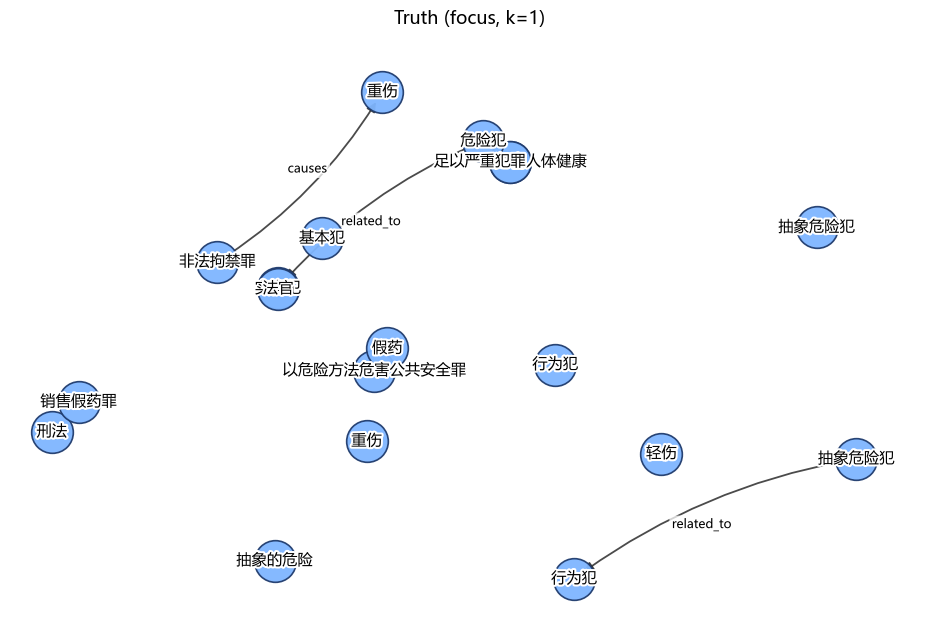

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test5_kg_focus_truth.png


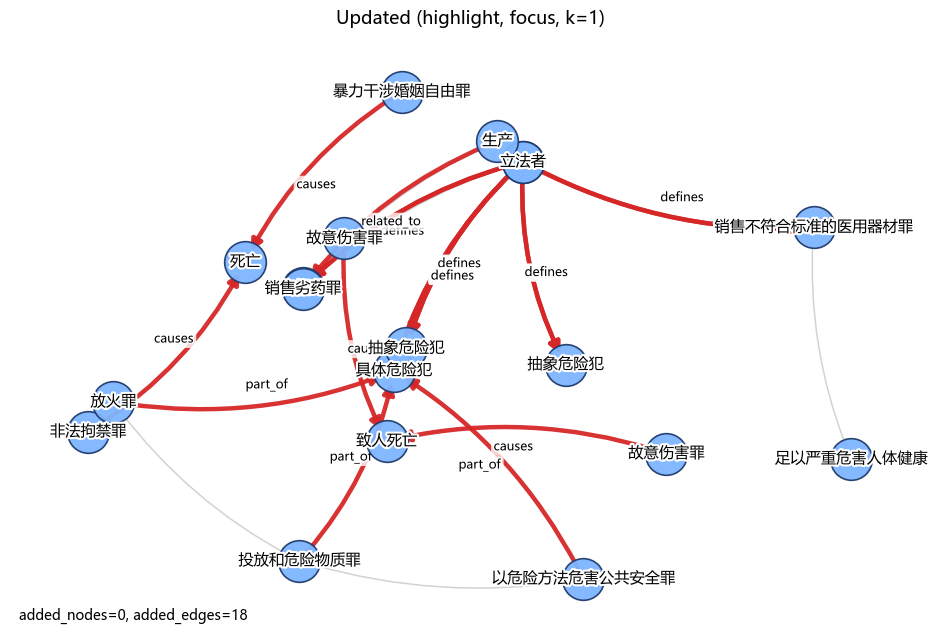

[Saved] D:\Desktop\KG_allprocess\Output\Step5_output\Figures\test5_kg_focus_updated_highlight.png
[Focus] nodes=19, added_edges=18, removed_edges=0


In [ ]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

# =========================================================
# 0) 路径配置
# =========================================================
i = 6

BASE_NODES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_nodes.tsv"
BASE_EDGES  = r"D:\Desktop\KG_allprocess\Output\Step4_output\test"+str(i)+"_KG_edges.tsv"

UPD_NODES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_nodes_updated.tsv"
UPD_EDGES   = r"D:\Desktop\KG_allprocess\Output\Step12_output\test"+str(i)+"_KG_edges_updated.tsv"

TRUTH_NODES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_nodes.tsv"
TRUTH_EDGES = r"D:\Desktop\KG_allprocess\Output\Step4.5_output\test"+str(i)+"_KG_edges.tsv"

OUT_DIR     = r"D:\Desktop\KG_allprocess\Output\Step5_output\Figures"
os.makedirs(OUT_DIR, exist_ok=True)

OUT_BASELINE = os.path.join(OUT_DIR, f"test{i}_kg_focus_baseline.png")
OUT_TRUTH    = os.path.join(OUT_DIR, f"test{i}_kg_focus_truth.png")
OUT_UPDATED  = os.path.join(OUT_DIR, f"test{i}_kg_focus_updated_highlight.png")

# 聚焦参数
K_HOP     = 1
MAX_NODES = 10

# 列名
NODE_NAME_COL = "name"
EDGE_SRC_COL  = "src_id"
EDGE_DST_COL  = "dst_id"
EDGE_REL_COL  = "relation_type"
NODE_ID_COL_CANDIDATES = ["id", "node_id", "entity_id", "nid"]

# 中文字体
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False


# =========================================================
# 1) 读图
# =========================================================
def load_kg_from_tsv(
    nodes_tsv,
    edges_tsv,
    directed=True,
    node_id_col=None,
    node_name_col="name",
    src_col="src_id",
    dst_col="dst_id",
    rel_col="relation_type",
):
    nodes = pd.read_csv(nodes_tsv, sep="\t")
    edges = pd.read_csv(edges_tsv, sep="\t")

    if node_id_col is None:
        for cand in NODE_ID_COL_CANDIDATES:
            if cand in nodes.columns:
                node_id_col = cand
                break
    if node_id_col is None or node_id_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到节点ID列。当前列={list(nodes.columns)}")

    for c in [src_col, dst_col, rel_col]:
        if c not in edges.columns:
            raise ValueError(f"[edges] 找不到列 '{c}'，当前列={list(edges.columns)}")
    if node_name_col not in nodes.columns:
        raise ValueError(f"[nodes] 找不到实体名列 '{node_name_col}'，当前列={list(nodes.columns)}")

    G = nx.DiGraph() if directed else nx.Graph()

    for _, r in nodes.iterrows():
        nid = str(r[node_id_col])
        name = str(r[node_name_col]) if pd.notna(r[node_name_col]) else nid
        name = name.strip()
        if not name:
            name = nid
        attrs = r.to_dict()
        attrs["display_name"] = name
        G.add_node(nid, **attrs)

    for _, r in edges.iterrows():
        u = str(r[src_col])
        v = str(r[dst_col])
        rel = str(r[rel_col]) if pd.notna(r[rel_col]) else ""
        rel = rel.strip()
        if not rel:
            rel = "?"
        G.add_edge(u, v, relation=rel)

    return G


def edge_keyset(G):
    s = set()
    for u, v, d in G.edges(data=True):
        s.add((u, d.get("relation", ""), v))
    return s


def make_union_graph(*graphs):
    U = nx.DiGraph()
    for g in graphs:
        U.add_nodes_from(g.nodes(data=True))
        U.add_edges_from(g.edges(data=True))
    return U


# =========================================================
# 2) k-hop 聚焦
# =========================================================
def k_hop_nodes(G_union, seeds, k=2, max_nodes=60):
    seeds = [s for s in seeds if s in G_union]
    if not seeds:
        return set()

    visited = set(seeds)
    q = deque([(s, 0) for s in seeds])

    while q:
        node, dist = q.popleft()
        if dist == k:
            continue

        neighbors = set(G_union.successors(node)) | set(G_union.predecessors(node))
        for nb in neighbors:
            if nb not in visited:
                visited.add(nb)
                q.append((nb, dist + 1))
                if max_nodes is not None and len(visited) >= max_nodes:
                    return visited
    return visited


# =========================================================
# 3) 绘图函数
# =========================================================
def _node_labels(G):
    return {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}

def _edge_labels(G):
    return {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}

def draw_plain_graph(G, pos, title, out_path, node_size=650, node_font=10, edge_font=9):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.axis("off")

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, node_color="#1f77b4")
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=14, width=1.6, edge_color="black")

    nx.draw_networkx_labels(G, pos, ax=ax, labels=_node_labels(G), font_size=node_font)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=_edge_labels(G), font_size=edge_font)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[Saved] {out_path}")


def draw_updated_highlight(G_base, G_upd, pos, title, out_path,
                          node_size=650, node_font=10, edge_font=9):
    """
    Updated 图：高亮新增节点/新增边
    - baseline已有节点：蓝色
    - 新增节点：橙色
    - baseline已有边：浅灰
    - 新增边：红色 + 更粗
    """
    base_nodes = set(G_base.nodes())
    upd_nodes  = set(G_upd.nodes())

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added_nodes = upd_nodes - base_nodes
    kept_nodes  = upd_nodes & base_nodes

    added_edges = upd_edges - base_edges
    kept_edges  = upd_edges & base_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.axis("off")

    # 节点：先画保留，再画新增（新增盖在上面更醒目）
    if kept_nodes:
        nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(kept_nodes),
                               node_size=node_size, node_color="#1f77b4")
    if added_nodes:
        nx.draw_networkx_nodes(G_upd, pos, ax=ax, nodelist=list(added_nodes),
                               node_size=int(node_size * 1.08), node_color="#ff7f0e")

    # 边：保留边淡灰，新增边红且更粗
    if kept_edges:
        nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(kept_edges),
                               arrows=True, arrowsize=14, width=1.2, edge_color="#b0b0b0", alpha=0.8)
    if added_edges:
        nx.draw_networkx_edges(G_upd, pos, ax=ax, edgelist=_to_uv(added_edges),
                               arrows=True, arrowsize=16, width=3.0, edge_color="#d62728", alpha=0.95)

    # 标签
    nx.draw_networkx_labels(G_upd, pos, ax=ax, labels=_node_labels(G_upd), font_size=node_font)

    # 只给新增边打关系标签（最突出更新）
    added_edge_labels = {(u, v): rel for (u, rel, v) in added_edges}
    if added_edge_labels:
        nx.draw_networkx_edge_labels(G_upd, pos, ax=ax, edge_labels=added_edge_labels, font_size=edge_font)

    ax.text(0.01, 0.01,
            f"added_nodes={len(added_nodes)}, added_edges={len(added_edges)}",
            transform=ax.transAxes, fontsize=10, va="bottom")

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()
    print(f"[Saved] {out_path}")

import matplotlib.patheffects as pe

def _node_labels(G):
    return {n: G.nodes[n].get("display_name", str(n)) for n in G.nodes()}

def _edge_labels(G):
    return {(u, v): d.get("relation", "") for u, v, d in G.edges(data=True)}

def _best_layout(G, seed=42):
    """
    小图优先用 kamada_kawai，更规整；失败再退 spring。
    """
    try:
        return nx.kamada_kawai_layout(G)
    except Exception:
        return nx.spring_layout(G, seed=seed)

import matplotlib.patheffects as pe

def _draw_labels_with_outline(G, ax, pos, labels, font_size=10):
    texts = nx.draw_networkx_labels(
        G,
        pos,
        ax=ax,
        labels=labels,
        font_size=font_size
    )
    # 白色描边，防止被边压住
    for t in texts.values():
        t.set_path_effects([
            pe.withStroke(linewidth=3, foreground="white")
        ])
    return texts


def draw_plain_graph_beauty(G, pos, title, out_path,
                            node_size=900, node_font=11, edge_font=9):
    fig = plt.figure(figsize=(9.5, 6.5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=13, pad=12)
    ax.axis("off")

    # 节点：浅蓝 + 深色边框
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=node_size,
        node_color="#7fb6ff",
        edgecolors="#1f3b6d",
        linewidths=1.2,
        alpha=0.95
    )

    # 边：弧形，细一点更清爽
    nx.draw_networkx_edges(
        G, pos, ax=ax,
        edge_color="#2b2b2b",
        width=1.3,
        alpha=0.85,
        arrows=True,
        arrowsize=14,
        connectionstyle="arc3,rad=0.12"
    )

    # 节点标签：描边
    _draw_labels_with_outline(G, ax, pos, _node_labels(G), font_size=node_font)


    # 边标签：加半透明白底
    e_labels = _edge_labels(G)
    if e_labels:
        texts = nx.draw_networkx_edge_labels(
            G, pos, ax=ax,
            edge_labels=e_labels,
            font_size=edge_font,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
            rotate=False,
            label_pos=0.55
        )
        for t in texts.values():
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    plt.tight_layout()
    plt.savefig(out_path, dpi=350, bbox_inches="tight")
    plt.show()
    print(f"[Saved] {out_path}")


def draw_updated_highlight_beauty(G_base, G_upd, pos, title, out_path,
                                  node_size=900, node_font=11, edge_font=9):
    base_nodes = set(G_base.nodes())
    upd_nodes  = set(G_upd.nodes())

    base_edges = edge_keyset(G_base)
    upd_edges  = edge_keyset(G_upd)

    added_nodes = upd_nodes - base_nodes
    kept_nodes  = upd_nodes & base_nodes

    added_edges = upd_edges - base_edges
    kept_edges  = upd_edges & base_edges

    def _to_uv(keys):
        return [(u, v) for (u, rel, v) in keys]

    fig = plt.figure(figsize=(9.5, 6.5))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=13, pad=12)
    ax.axis("off")

    # 先画保留边（浅灰弧线）
    if kept_edges:
        nx.draw_networkx_edges(
            G_upd, pos, ax=ax,
            edgelist=_to_uv(kept_edges),
            edge_color="#c7c7c7",
            width=1.1,
            alpha=0.8,
            arrows=True,
            arrowsize=12,
            connectionstyle="arc3,rad=0.12"
        )

    # 再画新增边（红色粗弧线）
    if added_edges:
        nx.draw_networkx_edges(
            G_upd, pos, ax=ax,
            edgelist=_to_uv(added_edges),
            edge_color="#d62728",
            width=3.2,
            alpha=0.95,
            arrows=True,
            arrowsize=16,
            connectionstyle="arc3,rad=0.14"
        )

    # 节点：保留节点浅蓝；新增节点橙色更醒目（稍大）
    if kept_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(kept_nodes),
            node_size=node_size,
            node_color="#7fb6ff",
            edgecolors="#1f3b6d",
            linewidths=1.2,
            alpha=0.95
        )
    if added_nodes:
        nx.draw_networkx_nodes(
            G_upd, pos, ax=ax,
            nodelist=list(added_nodes),
            node_size=int(node_size * 1.15),
            node_color="#ffb04a",
            edgecolors="#8a4b00",
            linewidths=1.4,
            alpha=0.98
        )

    # 节点标签：描边
    _draw_labels_with_outline(G_upd, ax, pos, _node_labels(G_upd), font_size=node_font)


    # 只给新增边打关系标签（白底）
    added_edge_labels = {(u, v): rel for (u, rel, v) in added_edges}
    if added_edge_labels:
        texts = nx.draw_networkx_edge_labels(
            G_upd, pos, ax=ax,
            edge_labels=added_edge_labels,
            font_size=edge_font,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8),
            rotate=False,
            label_pos=0.55
        )
        for t in texts.values():
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    # 角标统计
    ax.text(0.01, 0.01,
            f"added_nodes={len(added_nodes)}, added_edges={len(added_edges)}",
            transform=ax.transAxes, fontsize=10, va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.75))

    plt.tight_layout()
    plt.savefig(out_path, dpi=350, bbox_inches="tight")
    plt.show()
    print(f"[Saved] {out_path}")


def plot_three_separate_figures_beauty(k=1, max_nodes=10, seed=42):
    G_base  = load_kg_from_tsv(BASE_NODES,  BASE_EDGES,  node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_upd   = load_kg_from_tsv(UPD_NODES,   UPD_EDGES,   node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)
    G_truth = load_kg_from_tsv(TRUTH_NODES, TRUTH_EDGES, node_name_col=NODE_NAME_COL,
                              src_col=EDGE_SRC_COL, dst_col=EDGE_DST_COL, rel_col=EDGE_REL_COL)

    base_e = edge_keyset(G_base)
    upd_e  = edge_keyset(G_upd)
    added  = upd_e - base_e
    removed = base_e - upd_e

    changed_nodes = set()
    for (u, rel, v) in list(added) + list(removed):
        changed_nodes.add(u); changed_nodes.add(v)

    if not changed_nodes:
        print("[Warn] 未检测到变化边，将使用 Updated 的前若干节点作为 focus。")
        changed_nodes = set(list(G_upd.nodes())[:min(len(G_upd.nodes()), 5)])

    G_union = make_union_graph(G_base, G_upd, G_truth)
    focus_nodes = k_hop_nodes(G_union, changed_nodes, k=k, max_nodes=max_nodes)

    base_sub  = G_base.subgraph(focus_nodes).copy()
    upd_sub   = G_upd.subgraph(focus_nodes).copy()
    truth_sub = G_truth.subgraph(focus_nodes).copy()

    # ✅ 更好看的布局：在 focus 联合图上算
    union_sub = make_union_graph(base_sub, upd_sub, truth_sub)
    pos = _best_layout(union_sub, seed=seed)

    draw_plain_graph_beauty(base_sub,  pos, f"Baseline (focus, k={k})", OUT_BASELINE)
    draw_plain_graph_beauty(truth_sub, pos, f"Truth (focus, k={k})",    OUT_TRUTH)
    draw_updated_highlight_beauty(base_sub, upd_sub, pos, f"Updated (highlight, focus, k={k})", OUT_UPDATED)

    print(f"[Focus] nodes={len(focus_nodes)}, added_edges={len(added)}, removed_edges={len(removed)}")

plot_three_separate_figures_beauty(k=K_HOP, max_nodes=MAX_NODES)